<img src="header_recommender.png">

## Hintergrund

### Recommender-Systeme

Recommender-Systemen begegnen wir in unserem digitalen Alltag inzwischen mehrmals täglich:
Von einer Reihe von Services bekommen wir stetig neue Medien vorgeschlagen, die uns auch noch interessieren könnten. Die Selektion neuer passender Medien wird dabei mittels der akribisch aufgezeichneten Historie unseres bisherigen Konsums geführt. Einige Recommender-Systeme nutzen wir aktiv und bewusst, die Präsenz anderer bemerken wir vielleicht gar nicht. Einige solcher Systeme bringen uns tatsächlich einen Mehrwert, andere dienen vor allem dazu, uns länger in Webseiten und Applikationen verweilen zu lassen, um uns mehr Produkte oder mehr Werbung präsentieren zu können.

Aufgrund unserer bisherigen Historie (und, wie wir sehen werden, derjenigen von anderen Usern) schlägt uns zum Beispiel Youtube neue Videos, Netflix neue Filme und Serien, Spotify und Soundcloud neue Musik, Digitec und Amazon neue Produkte, Facebook und LinkedIn neue Freunde, NZZ und 20 Minuten neue Artikel, Google Play und Apple Store neue Apps, Google Maps und Trip Advisor neue Restaurants, die SBB App mögliche heutige Reisedestinationen vor, etc. Im Hintergrund berechnet zum Beispiel Google die optimalen Suchresultaten und die 'optimale' Werbung, die wir am ehesten anklicken.

Als Data Scientists möchten wir natürlich auch solche Recommender bauen und verstehen können. In dieser Anwendung gehen wir einen kleinen Schritt in diese Richtung, indem wir einen einfachen und bekannten Recommender-Algorithmus selbst umsetzen am Beispiel von Filmempfehlungen. Konkret befassen wir uns mit einem *IBCF-Recommender* (Item-based Collaborative Filtering) der Vektor-Ähnlichkeiten zwischen verschiedenen Filmen mittels Cosine-Similarity berechnet und die zu einem Film ähnlichen Filme vorschlagen kann.

### IBCF und Cosine-Similarity

Die Grundlage eines solchen IBCF-Recommendersystems ist die sogenannte *User-Item-* oder *Interaktionsmatrix*. In ihr werden Bewertungen für einen Item bzw. ein Produkt von verschiedenen Usern in einer Matrix zusammengefasst (im vorliegenden Bild für verschiedene Bücher):

<img src="user_item_matrix_example.png">

Alle User haben nur gewisse Bücher gelesen und dafür eine Bewertung abgegeben, viele Felder der Matrix sind nicht besetzt und müssen entsprechend mit einer Null oder einem fehlenden Wert gekennzeichnet werden. Die IBCF betrachtet nun jeden Item / jedes Produkt als Spaltenvektor aus Userratings und bestimmt Ähnlichkeiten zwischen diesen Spaltenvektoren. Wurde ein Produkt von ähnlichen Usern ähnlich bewertet, so wird angenommen, dass auch das Produkt ähnlich ist.

Konkret wird dafür die sogenannte **Cosine-Similarity** herangezogen:

Diese interessiert sich nicht für die Länge der Vektoren, sondern nur für deren Zwischenwinkel. Ist der Zwischenwinkel null, so sind sich die Vektoren komplett ähnlich. Ist der Zwischenwinkel 180°, so sind die Vektoren komplett verschieden. Dieser Zusammenhang lässt sich mit der Definition des Skalarprodukts über den Zwischenwinkel ausdrücken:

$$\mathbf{u} \cdot \mathbf{v} = |\mathbf{u}| \; |\mathbf{v}| \; \cos\alpha,$$

wobei $\mathbf{u}, \mathbf{v} \in \mathbb{R}^n$ Vektoren seien und $\alpha$ der Zwischenwinkel. Damit gilt die Zwischenwinkelformel

$$\cos\alpha = \frac{\mathbf{u} \cdot \mathbf{v}}{|\mathbf{u}| \; |\mathbf{v}|}.$$

Ist der Zwischenwinkel null, ist also $\cos\alpha = 1$, ist er 90°, so ist $\cos\alpha = 0$ und ist er 180°, so ist $\cos\alpha=-1$. Die Cosine-Similarity nimmt also Werte zwischen -1 (total verschieden) und 1 (identisch) an. Sind die Vektoren $\mathbf{u}$ und $\mathbf{v}$ vorgängig normiert worden, so entspricht die Cosine-Similarity gerade dem Skalarprodukt.

Hier ist interessant, dass wir die Cosine-Similarity nur die Fälle betrachten lassen können, wo beide User ein Rating abgegeben haben. Setzen wir nämlich die Felder der User-Item-Matrix in denen ein Rating fehlt gleich null, so tragen diese Felder nichts zur Cosine-Similarity bei (da das Skalarprodukt als Summe $\mathbf{u} \cdot \mathbf{v} = \sum_i u_i v_i$ berechnet wird und keine Beiträge entstehen, wenn $u_i$ oder $v_i$ null ist).

Wir können diese Methode nun benutzen, um zu einem Film den wir mögen ähnliche Filme zu finden. Dazu benutzen wir das [Movie-Lens](https://movielens.org/)-Datenset, das seit 1997 Film-Bewertungen mit einer wachsenden Userbase sammelt. In diesem Fall benutzen wir das [kleinstmögliche Datenset](https://www.kaggle.com/shubhammehta21/movie-lens-small-latest-dataset) mit nur 610 Users und 9742 Filmen, um den Rechenaufwand zu minimieren.

## Benötigte Libraries einbinden

Die folgenden Python-Bibliotheken reichen für die Bearbeitung dieses Anwendungsbeispiels

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## User-Item Matrix erstellen

Im folgenden erstellen wir die User-Item-Matrix. Das Data Wrangling ist hier bereits für Sie erledigt.

Daten einlesen:

In [240]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Bereinigungen durchführen:

In [241]:
movies['year'] = movies.title.str.extract("\((\d+)\)$").astype(float)
movies.title = movies.title.str.replace("\(\d+\)", "", regex=True)
movies.title = movies.title.str.replace(r'(.+), The', r'The \1', regex=True)
movies.title = movies.title.str.replace(r'(.+), A', r' \1', regex=True)
movies.title = movies.title.str.strip()
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


Filme ohne Rating entfernen:

In [245]:
movies = movies[movies.movieId.isin( ratings.movieId.unique() )].reset_index( drop=True )
movies.shape
print(movies.head())

   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres    year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
1                   Adventure|Children|Fantasy  1995.0  
2                               Comedy|Romance  1995.0  
3                         Comedy|Drama|Romance  1995.0  
4                                       Comedy  1995.0  


User-Item-Matrix erstellen:

In [246]:
I = pd.crosstab( ratings.userId, ratings.movieId, values=ratings.rating, aggfunc='mean', dropna=True ).fillna(0)
user_ids = I.index
movie_ids = I.columns
X = I.values

In [247]:
X

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

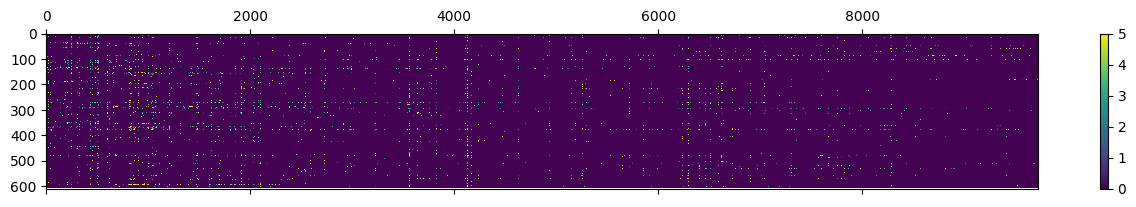

In [248]:
plt.matshow(X, aspect="auto")
plt.colorbar()

In [252]:
user_ids

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
      dtype='int64', name='userId', length=610)

In [253]:
movie_ids

Index([     1,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
       193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585, 193587,
       193609],
      dtype='int64', name='movieId', length=9724)

In [255]:
X.shape, len(user_ids), len(movie_ids)

((610, 9724), 610, 9724)

In [305]:
# dummy print
print(X)

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


## Ihre Aufgabe

### a) Einzelne Cosine-Similarity berechnen

Gegeben sei also die User-Item-Matrix $\mathbf{X} \in \mathbb{R}^{610 \times 9724}$. Die Cosine-Similarity zwischen Film $i$ und Film $j$ ist definiert als

$$S_{ij} = \frac{\mathbf{x}_i \cdot \mathbf{x}_j}{|\mathbf{x}_i| \; |\mathbf{x}_j|},$$

wobei $\mathbf{x}_i$ der i-te Spaltenvektor von $\mathbf{X}$ bezeichne. $S_{ij}$ beschreibt hier die Komponenten einer Ähnlichkeits-Matrix $\mathbf{S} \in \mathbb{R}^{9724 \times 9724}$.

Berechnen Sie als Beispiel die Cosine-Similarity zwischen den Filmen 'Star Wars: Episode IV - A New Hope' ($i=224$) und 'Star Wars: Episode V - The Empire Strikes Back' ($j=897$). Benutzen Sie dazu die Befehle `np.vdot()` und `np.linalg.norm()`. Definieren Sie dazu zuerst die Spaltenvektoren `xi` und `xj` und prüfen Sie, ob diese jeweils 610 Elemente besitzen (ein Rating pro User). Sind die Filme einander ähnlich?

Können Sie argumentieren, warum die Cosine-Similarity für alle Filmpaare nur Werte zwischen 0 und 1 annimmt?

In [270]:
# !! Datensatz !!
# Zeilen: User
# Spalten: Filme
# In diesem Datensatz hat es viel mehr Filme als User

# IHR CODE
i = 224
j = 897
xi = X[:, i]
xj = X[:, j]
xi.shape, xj.shape

((610,), (610,))

In [271]:
Sij = (np.dot(xi, xj) / (np.linalg.norm(xi) * np.linalg.norm(xj)))
Sij

0.8324073552233734

### b) Cosine-Similarity vektorisiert berechnen

Nun möchten wir die gesamte Matrix $S$ mit den Cosine-Similarities zwischen allen Filmen berechnen. Naiv könnten wir dies tun, indem wir z.B. mit zwei verschachtelten `for`-Loops über $i$ und $j$ iterieren und damit alle Matrixelemente $S_{ij}$ berechnen. Da $S$ aber eine ($9724\times9724$)-Matrix ist, hat diese ca. 95 Millionen Matrixelemente. Da Python eine Interpretersprache ist, sind `for`-Loops extrem ineffizient und die Berechnung von $S$ dauert über 10 Minuten. Es empfiehlt sich daher, möglichst auf `for`-Loops zu verzichten und mit Vektoren und Matrizen zu arbeiten. Die Numpy-Bibliothek ist kompiliert und dementsprechend effizient.

<br>

Es bietet sich folgende Überlegung an:

Haben wir alle Spaltenvektoren $\mathbf{x}_i$ von $X$ vorgängig normiert (also auf die Länge 1 gebracht, indem wir sie durch ihre Norm dividiert haben), so reduziert sich die obige Formel für ein einzelnes Matrixelement auf

$$
S_{ij} = \mathbf{x}_i \cdot \mathbf{x}_j.
$$

Über die Matrizenmultiplikation lässt sich leicht zeigen, dass dann gerade $S = X^T X$, wobei das Matrixelement  $S_{ij}$ von $S$ gerade die Ähnlichkeit zwischen $i$ und $j$ bezeichnet.

<br>

Berechnen Sie nun die Cosine-Similarity in folgenden Schritten:

1. Berechnen Sie die Normen aller Spaltenvektoren von $X$ mit `np.linalg.norm()` und dem Setzen eines geeigneten Werts für den `axis`-Parameter.

2. Dividieren Sie die Matrix $X$ durch diesen Zeilenvektor aus Normen (Stichwort [Broadcasting](https://numpy.org/doc/1.20/user/theory.broadcasting.html)) und speichern Sie die normierte Matrix als `Xnorm`. 

3. Berechnen Sie $\mathbf{S} = \mathbf{X}^T \mathbf{X}$, indem Sie für $X$ ihre normierte Interkationsmatrix `Xnorm` benutzen.

4. Stellen Sie sicher, dass $\mathbf{S}$ die korrekten Dimensionen besitzt.

In [306]:
# Normen aller Spalten
normX = np.linalg.norm(X, axis=0)
print(normX)
print(normX.shape)

[58.77499468 37.15171598 24.68299009 ...  3.5         3.5
  4.        ]
(9724,)


In [276]:
# Normierung
Xnorm = X / normX
Xnorm

array([[0.06805615, 0.        , 0.16205492, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0425351 , 0.05383331, 0.08102746, ..., 0.        , 0.        ,
        0.        ],
       [0.05104211, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08507019, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [277]:
# S berechnen
S = np.dot(Xnorm.T, Xnorm)
S

array([[1.        , 0.41056206, 0.2969169 , ..., 0.        , 0.        ,
        0.        ],
       [0.41056206, 1.        , 0.28243799, ..., 0.        , 0.        ,
        0.        ],
       [0.2969169 , 0.28243799, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [278]:
# Shape überprüfen
S.shape

(9724, 9724)

Matrix darstellen

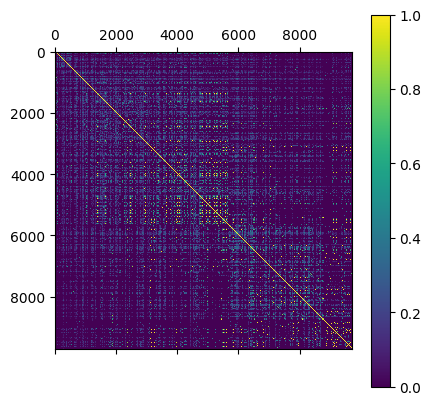

In [280]:
plt.matshow(S)
plt.colorbar()

### c) Ähnliche Filme finden

Nun möchten wir zu ihrem Lieblingsfilm ähnliche Filme finden. Finden Sie dazu zuerst die `movieId` ihres Films, indem Sie nach dem Titel des Films suchen:

In [284]:
movie = movies[movies.title.str.contains("Rogue One: A Star Wars Story")]
movie

,movieId,title,genres,year
9415,166528,Rogue One: A Star Wars Story,Action|Adventure|Fantasy|Sci-Fi,2016.0


Ausserdem setzen wir die Ähnlichkeit aller Filme mit sich selbst auf Null:

In [286]:
d = np.arange(S.shape[0])
S[d,d] = 0

Sie können nun die folgende Funktion für eine Recommendation aufgrund ihrer Ähnlichkeitsmatrix verwenden (und optional verstehen):

In [297]:
def ibcf_recommend( movieId, S, sim_thresh=0.3 ):
    i = np.where( movie_ids == movieId )[0][0]
    ibcf_rec = pd.DataFrame( {
        'movieId': movie_ids[np.argsort( S[i,:] )][::-1], 
        'similarity': np.sort(S[i,:])[::-1] 
    } )
    ibcf_rec = ibcf_rec[ibcf_rec.similarity>=sim_thresh]
    ibcf_rec = ibcf_rec.merge(movies, on="movieId")
    return ibcf_rec

Im Prinzip sucht diese Funktion zum gegebenen Film die Filme mit der höchsten Ähnlichkeit. Hat der Film den Index $i$ in $\mathbf{S}$, so suchen wir also die $j$, für die $S_{ij}$ nahe bei 1 ist. Der ganze Vorgang ist etwas komplizierter, weil nicht alle Filme bewertet sind und daher das Feld `movieId` nicht zwingend mit dem entsprechenden Index in der Matrix $\mathbf{S}$ übereinstimmt.

In [293]:
movieId = movie.movieId.values[0]
# print(movieId)
ibcf_recommend( movieId=movieId, S=S )

,movieId,similarity,title,genres,year
0,122922,0.670654,Doctor Strange,Action|Adventure|Sci-Fi,2016.0
1,135143,0.650007,Fantastic Beasts and Where to Find Them,Fantasy,2016.0
2,103042,0.643405,Man of Steel,Action|Adventure|Fantasy|Sci-Fi|IMAX,2013.0
3,168252,0.602710,Logan,Action|Sci-Fi,2017.0
4,135569,0.597957,Star Trek Beyond,Action|Adventure|Sci-Fi,2016.0
...,...,...,...,...,...
389,8636,0.301109,Spider-Man 2,Action|Adventure|Sci-Fi|IMAX,2004.0
390,100611,0.301047,Escape from Planet Earth,Adventure|Animation|Comedy|Sci-Fi,2013.0
391,53125,0.300888,Pirates of the Caribbean: At World's End,Action|Adventure|Comedy|Fantasy,2007.0
392,52458,0.300713,Disturbia,Drama|Thriller,2007.0


## Mögliche interessante Zusatzaufgaben

### Zusatz 1: Speedup durch Vektorisierung

Versuchen Sie $\mathbf{S}$ zu bestimmen, indem Sie mit zwei `for`-Schlaufen über $i$ und $j$ Stück für Stück die Matrixelemente $S_{ij}$ berechnen. Um welchen Faktor ist diese Methode langsamer als die vorgeschlagene Variante? Was ist der Grund hierfür?

In [322]:
# IHR CODE
import time
from tqdm.auto import tqdm

# S2 mit for loops berechnen
n = X.shape[1]
S2 = np.zeros( ( n, n ) )
for i in tqdm(range(n)):
    S2[i, i] = 1
    for j in range(i+1, n):
        xi = X[:, i]
        xj = X[:, j]
        S2[i, j] = np.dot(xi, xj) / (np.linalg.norm(xi) * np.linalg.norm(xj))
        S2[j,i] = S2[i,j]




100%|█████████████████████████████████| 9724/9724 [02:43<00:00, 59.51it/s]


In [323]:
# # hits auf sich selber auf 0 setzen
d = np.arange(S2.shape[0])
S2[d,d] = 0

In [324]:
# matrix ausgeben
print(S2)
print(S2.shape)

[[0.         0.41056206 0.2969169  ... 0.         0.         0.        ]
 [0.41056206 0.         0.28243799 ... 0.         0.         0.        ]
 [0.2969169  0.28243799 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(9724, 9724)


In [326]:
# check result
movie1 = ibcf_recommend( movieId=movieId, S=S )
movie2 = ibcf_recommend( movieId=movieId, S=S2 )

print(movie1)
print(movie2)

     movieId  similarity                                     title  \
0     122922    0.670654                            Doctor Strange   
1     135143    0.650007   Fantastic Beasts and Where to Find Them   
2     103042    0.643405                              Man of Steel   
3     168252    0.602710                                     Logan   
4     135569    0.597957                          Star Trek Beyond   
..       ...         ...                                       ...   
389     8636    0.301109                              Spider-Man 2   
390   100611    0.301047                  Escape from Planet Earth   
391    53125    0.300888  Pirates of the Caribbean: At World's End   
392    52458    0.300713                                 Disturbia   
393    89470    0.300458                                 Contagion   

                                   genres    year  
0                 Action|Adventure|Sci-Fi  2016.0  
1                                 Fantasy  2016.0  
2  

### Zusatz 2: UBCF

Sie können mit einer leichten Anpassung der obigen Methode auch User finden, die zueinander ähnlich sind. Was müssen Sie an der Implementierung ändern, damit dies möglich wird?

In [335]:
# IHR CODE
Xnorm2 = X.T / np.linalg.norm(X.T, axis=0)
S_UBCF = Xnorm2.T.dot(Xnorm2)

d2 = np.arange(S_UBCF.shape[0])
S_UBCF[d2,d2] = 0
S_UBCF


array([[0.        , 0.02728287, 0.05972026, ..., 0.29109737, 0.09357193,
        0.14532081],
       [0.02728287, 0.        , 0.        , ..., 0.04621095, 0.0275654 ,
        0.10242675],
       [0.05972026, 0.        , 0.        , ..., 0.02112846, 0.        ,
        0.03211875],
       ...,
       [0.29109737, 0.04621095, 0.02112846, ..., 0.        , 0.12199271,
        0.32205486],
       [0.09357193, 0.0275654 , 0.        , ..., 0.12199271, 0.        ,
        0.05322546],
       [0.14532081, 0.10242675, 0.03211875, ..., 0.32205486, 0.05322546,
        0.        ]])